## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

Adding features to this dataset can help us better understand it. Let's start with some simple calendar features like day of week and time of day. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import holidays
from darts import TimeSeries
from darts.models import NaiveSeasonal, Theta, RegressionModel, LightGBMModel
from darts.metrics import mape, rmse, mae

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


# Read a pandas DataFrame 2023
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
load2024 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2024.csv", delimiter=",")
load_df = pd.concat([load2023, load2024], ignore_index=True)

# Read temperature data
weather_data = pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";", skiprows=9)

# Process load data
load_df['Time (UTC)'] = load_df['Time (UTC)'].str.split(' - ').str[0]
load_df = load_df.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3', axis=1)   
load_df = load_df.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
load_df['datetime'] = pd.to_datetime(load_df['completetime'], format='%d.%m.%Y %H:%M')
load_df = load_df.drop(['completetime'], axis=1)

# Create datetime in weather_data - adjust column names as needed
date_col = 'Datum'  # Adjust this to your actual date column name
time_col = 'Tid (UTC)'  # Adjust this to your actual time column name

# Create datetime column in weather_data by combining date and time
weather_data['datetime'] = pd.to_datetime(
    weather_data[date_col].astype(str) + ' ' + weather_data[time_col].astype(str)
)

# Create a temporary dataframe with just datetime and temperature
temp_df = weather_data[['datetime', 'Lufttemperatur']].copy()
temp_df.rename(columns={'Lufttemperatur': 'Temperature'}, inplace=True)

# Remove any duplicates in temperature data
if temp_df['datetime'].duplicated().any():
    print(f"Found {temp_df['datetime'].duplicated().sum()} duplicate timestamps in temperature data")
    temp_df = temp_df.drop_duplicates(subset=['datetime'])

# Merge the dataframes based on datetime
print(f"Load data shape before merge: {load_df.shape}")
load_df = load_df.merge(temp_df, on='datetime', how='left')
print(f"Load data shape after merge: {load_df.shape}")

# Check for missing temperature values and identify where they are
missing_temp = load_df['Temperature'].isna().sum()
print(f"\nMissing temperature values after merge: {missing_temp}")

if missing_temp > 0:
    # Find rows with missing temperature values
    missing_rows = load_df[load_df['Temperature'].isna()]
    
    # Display information about the missing data
    print("\nRows with missing temperature values:")
    print(f"Total missing values: {len(missing_rows)}")
    
    # Show the first few rows with missing values
    print("\nFirst 10 rows with missing temperature values:")
    print(missing_rows[['datetime', 'Load']].head(10))
    
    # Show the distribution of missing values by month and hour
    print("\nMissing values by month:")
    print(missing_rows['datetime'].dt.month.value_counts().sort_index())
    
    print("\nMissing values by hour of day:")
    print(missing_rows['datetime'].dt.hour.value_counts().sort_index())
    
    # Check if missing values are consecutive
    missing_rows_sorted = missing_rows.sort_values('datetime')
    time_diff = missing_rows_sorted['datetime'].diff()
    
    print("\nTime differences between consecutive missing values (first 10):")
    print(time_diff.head(10))
    
    # Identify gaps in temperature data
    common_diff = time_diff.mode()[0]
    print(f"Most common time difference between missing values: {common_diff}")
    
    # Set datetime as index for time-based interpolation
    load_df_temp = load_df.set_index('datetime')
    
    # Perform interpolation
    load_df_temp['Temperature'] = load_df_temp['Temperature'].interpolate(method='time')
    
    # Handle any remaining missing values
    load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')
    
    # Reset index
    load_df = load_df_temp.reset_index()
    
    print(f"\nRemaining missing values after interpolation: {load_df['Temperature'].isna().sum()}")

# Adding day type
load_df['Day_of_week'] = load_df['datetime'].dt.dayofweek
load_df['Hour_of_day'] = load_df['datetime'].dt.hour

# Adding Holidays
Sweden_holidays = holidays.CountryHoliday('SE')
load_df['Holidays'] = [int(date in Sweden_holidays) for date in load_df.datetime]

# Reorder columns
load_df = load_df[['datetime', 'Load', 'Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays']]

# Display a sample of the final dataframe
print("\nFinal dataframe sample:")
print(load_df.head())

# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Temperature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Holidays"]
)

load_df



Load data shape before merge: (17544, 2)
Load data shape after merge: (17544, 3)

Missing temperature values after merge: 9

Rows with missing temperature values:
Total missing values: 9

First 10 rows with missing temperature values:
                 datetime   Load
6800  2023-10-11 08:00:00   9888
6801  2023-10-11 09:00:00   9850
6802  2023-10-11 10:00:00   9679
6803  2023-10-11 11:00:00   9544
6805  2023-10-11 13:00:00   9245
6943  2023-10-17 07:00:00  10537
6944  2023-10-17 08:00:00  10341
14983 2024-09-16 07:00:00   9398
14984 2024-09-16 08:00:00   9359

Missing values by month:
datetime
9     2
10    7
Name: count, dtype: int64

Missing values by hour of day:
datetime
7     2
8     3
9     1
10    1
11    1
13    1
Name: count, dtype: int64

Time differences between consecutive missing values (first 10):
6800                  NaT
6801      0 days 01:00:00
6802      0 days 01:00:00
6803      0 days 01:00:00
6805      0 days 02:00:00
6943      5 days 18:00:00
6944      0 days 01:00

,datetime,Load,Temperature,Day_of_week,Hour_of_day,Holidays
0,2023-01-01 00:00:00,8943,3.6,6,0,1
1,2023-01-01 01:00:00,8929,3.0,6,1,1
2,2023-01-01 02:00:00,8887,2.6,6,2,1
3,2023-01-01 03:00:00,8859,2.4,6,3,1
4,2023-01-01 04:00:00,8880,2.0,6,4,1
...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,11092,-2.1,1,19,1
17540,2024-12-31 20:00:00,10798,-1.8,1,20,1
17541,2024-12-31 21:00:00,10531,-3.0,1,21,1
17542,2024-12-31 22:00:00,10165,-2.7,1,22,1


In [2]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from darts.models import CatBoostModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV

# Make sure datetime is parsed
#load_df['datetime'] = pd.to_datetime(load_df['datetime'])
load_df = load_df.set_index('datetime')

# Define Features and Target
X = load_df[['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays']]
y = load_df['Load']

# Split data (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# --- Train CatBoost ---
param_grid = {'depth': [3, 4, 5, 6, 10],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [500, 1000, 3000]
              }

# Use MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Must be negative for GridSearchCV

# Run GridSearchCV
cat_model = GridSearchCV(
    CatBoostRegressor(silent=True),
    param_grid,
    scoring=mae_scorer,
    cv=3,  # 3-fold cross-validation
    verbose=100,

)
cat_model.fit(X_train, y_train)

# Best model
best_model = cat_model.best_estimator_
print("Best Parameters:", cat_model.best_params_)

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate both MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)


Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3; 1/45] START depth=3, iterations=500, learning_rate=0.01................
[CV 1/3; 1/45] END depth=3, iterations=500, learning_rate=0.01;, score=-512.038 total time=   0.5s
[CV 2/3; 1/45] START depth=3, iterations=500, learning_rate=0.01................
[CV 2/3; 1/45] END depth=3, iterations=500, learning_rate=0.01;, score=-716.110 total time=   0.5s
[CV 3/3; 1/45] START depth=3, iterations=500, learning_rate=0.01................
[CV 3/3; 1/45] END depth=3, iterations=500, learning_rate=0.01;, score=-541.975 total time=   0.5s
[CV 1/3; 2/45] START depth=3, iterations=500, learning_rate=0.05................
[CV 1/3; 2/45] END depth=3, iterations=500, learning_rate=0.05;, score=-478.847 total time=   0.4s
[CV 2/3; 2/45] START depth=3, iterations=500, learning_rate=0.05................
[CV 2/3; 2/45] END depth=3, iterations=500, learning_rate=0.05;, score=-616.248 total time=   0.5s
[CV 3/3; 2/45] START depth=3, iteratio

In [3]:
print(f"Lowest MAE: {mae:.2f}")
print(f"Corresponding MAPE: {mape:.4f}")

Lowest MAE: 467.81
Corresponding MAPE: 0.0496


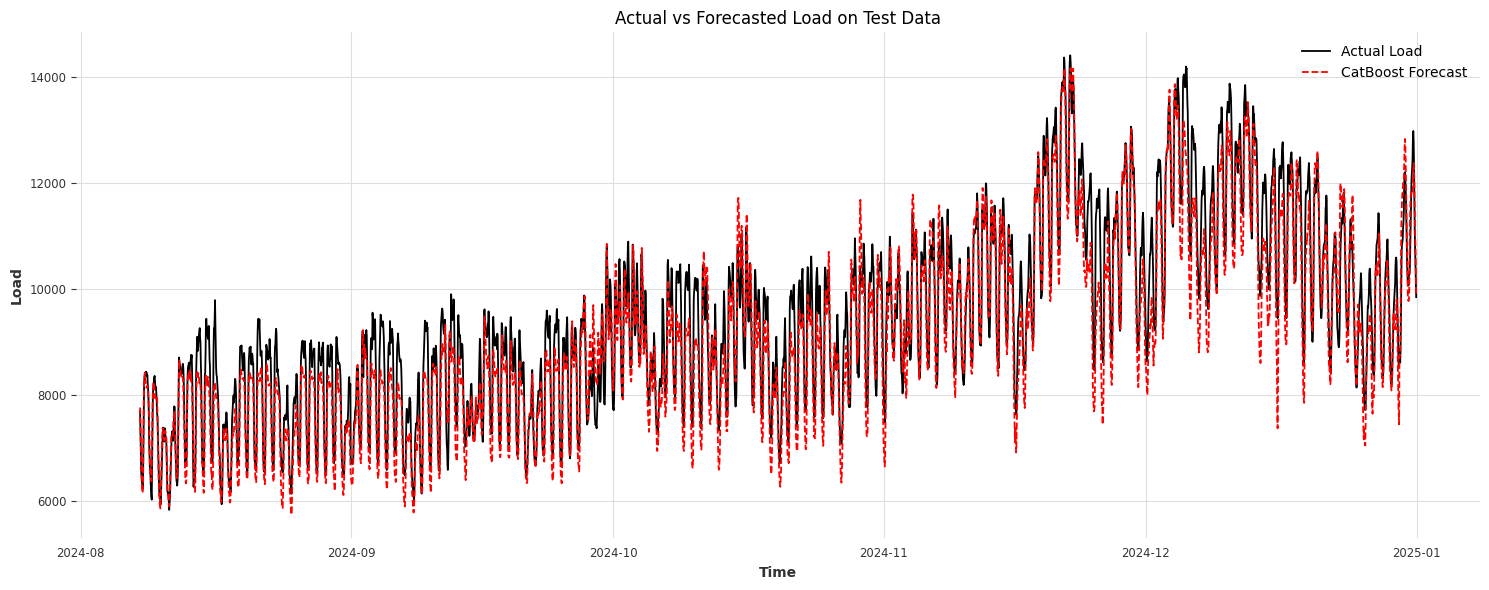

In [4]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_test, label='Actual Load', color='black')
plt.plot(y_test.index, y_pred, label='CatBoost Forecast', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load on Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y_train.index, y_train, label='Actual Load', color='black')
plt.plot(y_train.index, cat_pred_train, label='CatBoost Forecast', color= 'blue', linestyle='--')
plt.title('Actual vs Forecasted Load on Train Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

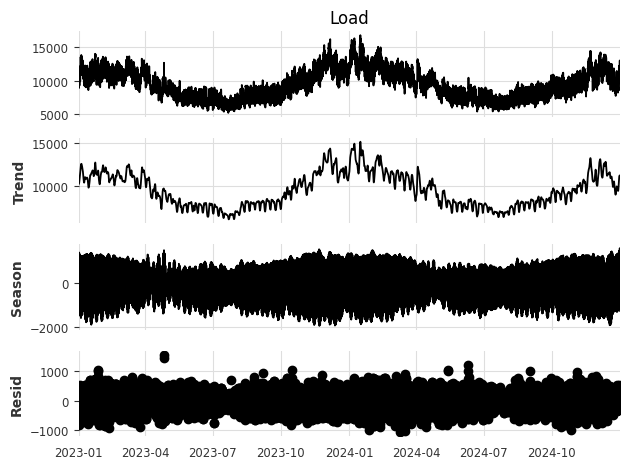

In [10]:
result = STL(load_df['Load'], period=24).fit()
_ = result.plot()

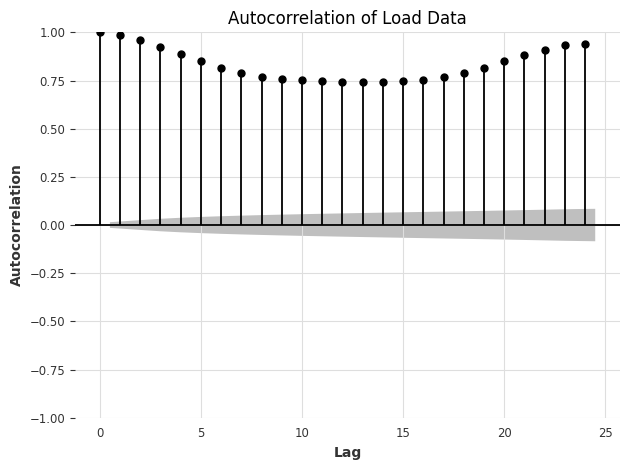

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF
plot_acf(load_df['Load'], lags=24)  # You can adjust the lags value as needed
plt.title('Autocorrelation of Load Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

Predict 24 hours ahead

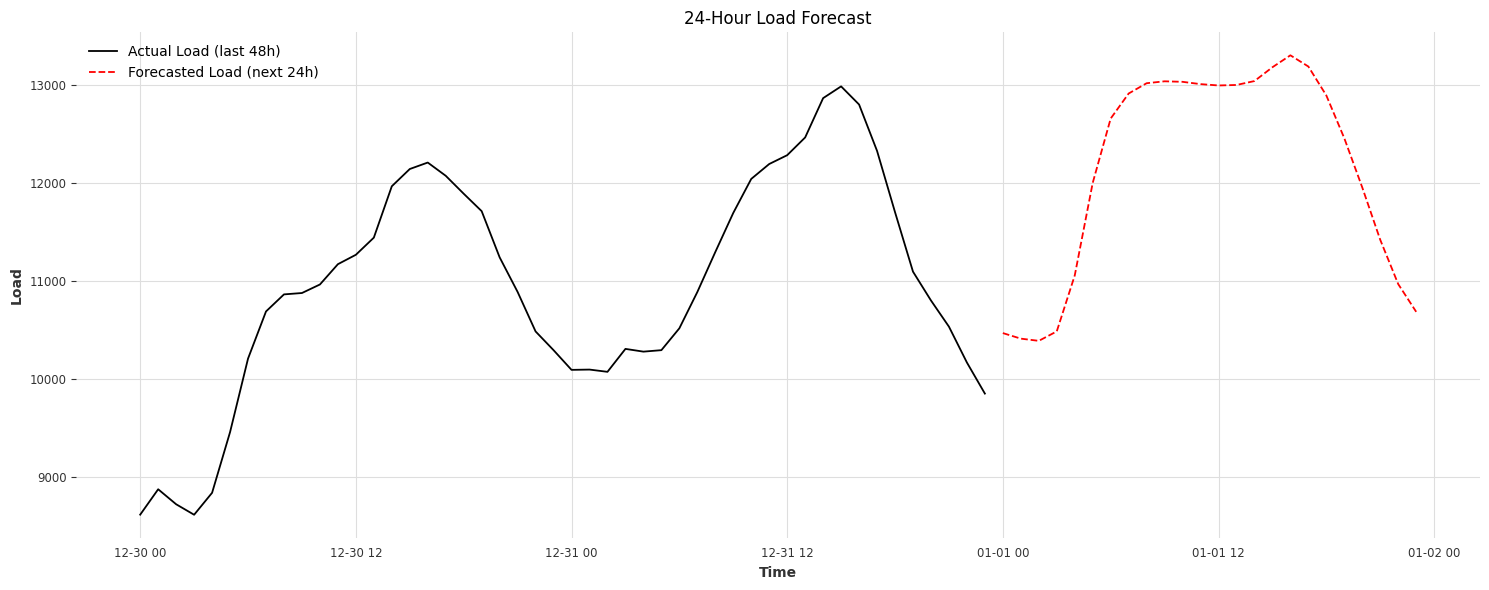

In [12]:
last_known = load_df.iloc[-24:].copy()  # Get last 24 rows
future_predictions = []
current_time = load_df.index[-1]

for step in range(24):
    # Step 1: Generate future time
    current_time += pd.Timedelta(hours=1)
    hour = current_time.hour
    day_of_week = current_time.dayofweek
    holiday = 1 if current_time.date() in load_df[load_df['Holidays'] == 1].index.date else 0
    temp = last_known['Temperature'].iloc[-1]  # or use weather forecast
    
    # Step 2: Prepare input
    lag_1 = last_known['Load'].iloc[-1]
    lag_24 = last_known['Load'].iloc[-24] if len(last_known) >= 24 else lag_1
    rolling = last_known['Load'].iloc[-24:].mean()
    
    x_input = pd.DataFrame([{
        'Temperature': temp,
        'Day_of_week': day_of_week,
        'Hour_of_day': hour,
        'Holidays': holiday,
        'lag_1': lag_1,
        'lag_24': lag_24,
        'rolling_mean_24': rolling
    }])
    
    # Step 3: Predict and store
    y_pred_24 = best_model.predict(x_input)[0]
    future_predictions.append((current_time, y_pred_24))
    
    # Step 4: Update last_known to include new prediction
    new_row = pd.DataFrame({
        'Load': [y_pred_24],
        'Temperature': [temp],
        'Day_of_week': [day_of_week],
        'Hour_of_day': [hour],
        'Holidays': [holiday]
    }, index=[current_time])
    
    # Add lag/rolling info (placeholders for consistency)
    new_row['lag_1'] = lag_1
    new_row['lag_24'] = lag_24
    new_row['rolling_mean_24'] = rolling
    
    last_known = pd.concat([last_known, new_row]).iloc[1:]  # Keep size steady

# 3. Plot the forecast
forecast_index, forecast_values = zip(*future_predictions)
plt.figure(figsize=(15,6))
plt.plot(load_df['Load'].iloc[-48:], label='Actual Load (last 48h)', color='black')
plt.plot(forecast_index, forecast_values, label='Forecasted Load (next 24h)', linestyle='--', color='red')
plt.title('24-Hour Load Forecast')
plt.xlabel('Time')
plt.ylabel('Load')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

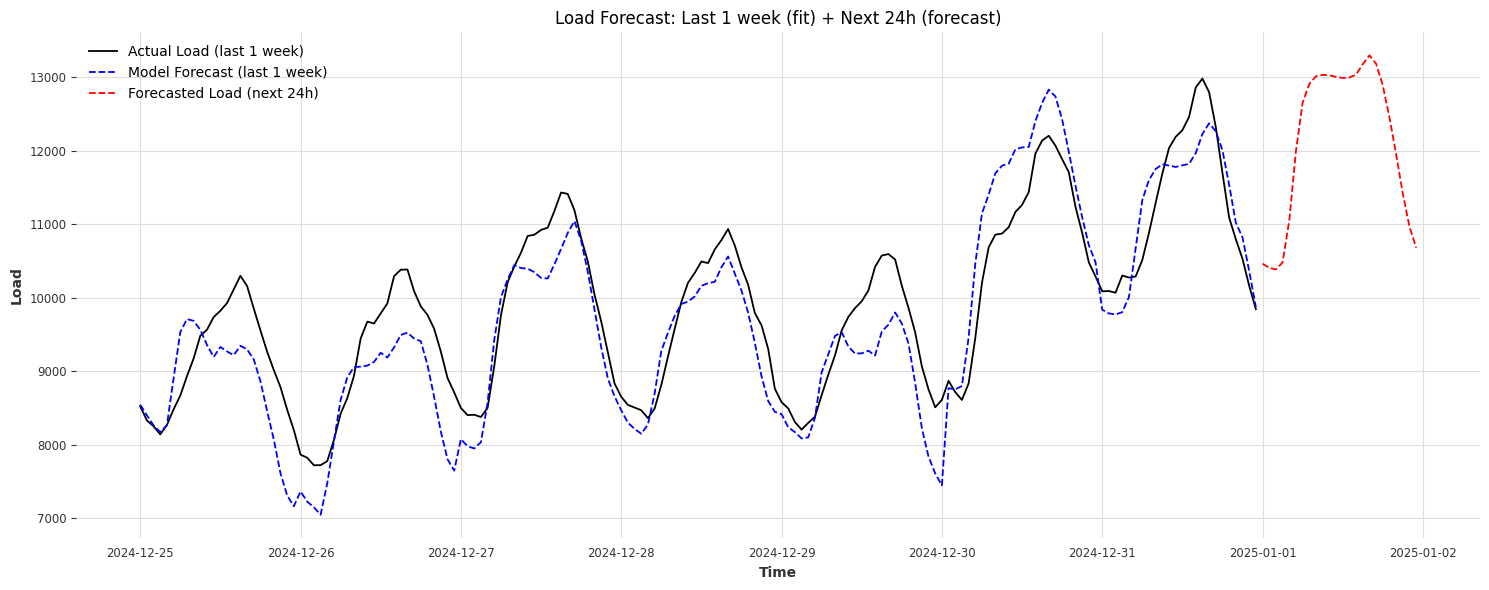

In [13]:
# 4. Predict the last 48 hours using the trained model
X_last168 = X.iloc[-168:]
y_last168_actual = y.iloc[-168:]
y_last168_pred = best_model.predict(X_last168)

# 5. Create final plot with all 3:
forecast_index, forecast_values = zip(*future_predictions)

plt.figure(figsize=(15, 6))

# Actual Load (last 1 week)
plt.plot(y_last168_actual.index, y_last168_actual, label='Actual Load (last 1 week)', color='black')

# Model's forecast during those same 48 hours
plt.plot(y_last168_actual.index, y_last168_pred, label='Model Forecast (last 1 week)', linestyle='--', color='blue')

# 24-hour ahead forecast
plt.plot(forecast_index, forecast_values, label='Forecasted Load (next 24h)', linestyle='--', color='red')

plt.title('Load Forecast: Last 1 week (fit) + Next 24h (forecast)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Predict on test set
#y_last168pred = best_model.predict(x_input)

# Evaluate both MAE and MAPE
mae_168 = mean_absolute_error(y_test, y_last168_pred)
mape_168 = mean_absolute_percentage_error(y_test, y_last168_pred)

In [11]:
from darts.models import CatBoostModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV

# Make sure datetime is parsed
load_df = load_df.set_index('datetime')

# Define Features and Target
X = load_df[['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays']]
#future_cov= load_df[['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays']]
y = load_df['Load']

# Split data (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

catboost_darts= CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6],
    output_chunk_length=6
)
#catboost_darts.fit(target, past_covariates=past_cov, future_covariates=future_cov)
catboost_darts.fit(X_train, y_train)
pred_24 = catboost_darts.predict(24)
pred_24.values()


KeyError: 0